<a href="https://colab.research.google.com/github/Freeman-gif/CNN-U-net/blob/main/double_u_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tifffile as tiff
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [5]:
IMG_HEIGHT = 768
IMG_WIDTH = 1024
IMG_CHANNELS = 1


In [7]:
# Open the image file
x_train= tiff.imread('/content/drive/MyDrive/intenship/training.tif')
y_train = tiff.imread('/content/drive/MyDrive/intenship/training_groundtruth.tif')

x_train= np.expand_dims(x_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)

In [8]:
y_train.shape,x_train.shape

((165, 768, 1024, 1), (165, 768, 1024, 1))

In [9]:
x_train = x_train.astype('float32') / 255.0
y_train = y_train.astype('float32') / 255.0

In [10]:
def iou(y_true, y_pred, smooth=1):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.keras.backend.sum(y_true,[1,2,3])+tf.keras.backend.sum(y_pred,[1,2,3])-intersection
    iou = tf.keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [11]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


In [12]:
from keras.models import Model, load_model

from keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *

def contraction_path(input_tensor, filters):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_tensor)
    x = Dropout(0.1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    p = MaxPooling2D((2, 2))(x)
    return x, p

# Function for the expansive path (upsampling)
def expansive_path(input_tensor, skip_tensor, filters):
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = concatenate([x, skip_tensor])
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    return x

# Build the first U-Net
inputs = Input((768, 1024, 1))
s = Lambda(lambda x: x / 255)(inputs)

c1, p1 = contraction_path(s, 16)
c2, p2 = contraction_path(p1, 32)
c3, p3 = contraction_path(p2, 64)
c4, p4 = contraction_path(p3, 128)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = expansive_path(c5, c4, 128)
u7 = expansive_path(u6, c3, 64)
u8 = expansive_path(u7, c2, 32)
u9 = expansive_path(u8, c1, 16)

outputs1 = Conv2D(1, (1, 1), activation='sigmoid')(u9)

# Process the output of the first U-Net before feeding it to the second
processed_first_output = Multiply()([s, outputs1])  # This assumes you want to element-wise multiply the input with the output mask from the first U-Net

# Build the second U-Net using the processed output from the first U-Net
c1_2, p1_2 = contraction_path(processed_first_output, 16)
c2_2, p2_2 = contraction_path(p1_2, 32)
c3_2, p3_2 = contraction_path(p2_2, 64)
c4_2, p4_2 = contraction_path(p3_2, 128)

c5_2 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4_2)
c5_2 = Dropout(0.3)(c5_2)
c5_2 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5_2)

u6_2 = expansive_path(c5_2, c4_2, 128)
u7_2 = expansive_path(u6_2, c3_2, 64)
u8_2 = expansive_path(u7_2, c2_2, 32)
u9_2 = expansive_path(u8_2, c1_2, 16)

outputs2 = Conv2D(1, (1, 1), activation='sigmoid')(u9_2)

# Final model
model = Model(inputs=[inputs], outputs=[outputs2])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, iou])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 768, 1024, 1)]       0         []                            
                                                                                                  
 lambda (Lambda)             (None, 768, 1024, 1)         0         ['input_8[0][0]']             
                                                                                                  
 conv2d_114 (Conv2D)         (None, 768, 1024, 16)        160       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 768, 1024, 16)        0         ['conv2d_114[0][0]']          
                                                                                            

In [28]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, iou])

In [15]:
callbacks=[tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
           tf.keras.callbacks.TensorBoard(log_dir='logs')]


In [29]:
results=model.fit(x_train,y_train,validation_split=0.1,batch_size=4,epochs=64,callbacks=callbacks)

Epoch 1/64
37/37 [==============================] - 81s 1s/step - loss: 0.3381 - accuracy: 0.9064 - dice_coefficient: 0.0715 - iou: 0.0364 - val_loss: 0.2152 - val_accuracy: 0.9583 - val_dice_coefficient: 0.0595 - val_iou: 0.0307
Epoch 2/64
37/37 [==============================] - 41s 1s/step - loss: 0.2257 - accuracy: 0.9420 - dice_coefficient: 0.0655 - iou: 0.0331 - val_loss: 0.1746 - val_accuracy: 0.9583 - val_dice_coefficient: 0.0635 - val_iou: 0.0328
Epoch 3/64
37/37 [==============================] - 41s 1s/step - loss: 0.2135 - accuracy: 0.9420 - dice_coefficient: 0.0783 - iou: 0.0399 - val_loss: 0.1808 - val_accuracy: 0.9583 - val_dice_coefficient: 0.0843 - val_iou: 0.0440
Epoch 4/64
37/37 [==============================] - 42s 1s/step - loss: 0.1627 - accuracy: 0.9420 - dice_coefficient: 0.1882 - iou: 0.1038 - val_loss: 0.1474 - val_accuracy: 0.9583 - val_dice_coefficient: 0.2001 - val_iou: 0.1112
Epoch 5/64
37/37 [==============================] - 42s 1s/step - loss: 0.1168 -

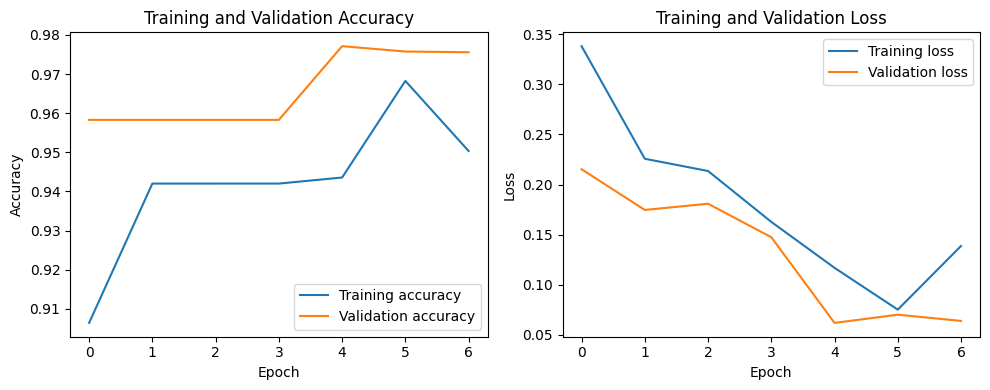

In [30]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
history = results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [31]:
x_test = tiff.imread('/content/drive/MyDrive/intenship/testing.tif')

In [32]:
x_test = np.expand_dims(x_test, axis=-1)

In [33]:
x_test = x_test.astype('float32') / 255.0

In [50]:
predict_test=model.predict(x_test,verbose=1)

InvalidArgumentError: ignored

In [36]:
print(predict_test[0].max())  # Should be greater than the threshold if there are positive predictions

0.876332


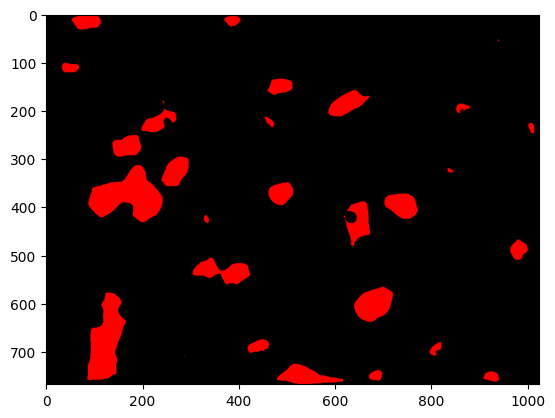

In [38]:
# Assuming predict_test is your model output and x_test is the normalized test image
thresholded_mask = (predict_test[0] > 0.5).astype(np.uint8)  # Apply threshold

# Remove the extra channel dimension from thresholded_mask if necessary
thresholded_mask_squeezed = np.squeeze(thresholded_mask)

# Create an RGB version of the grayscale image for visualization
x_test_rgb = np.stack((x_test[0, ..., 0],) * 3, axis=-1)

# Overlay the mask on the image
# The mask is used as a condition, and where it's true, we'll show the mask
# Where it's false, we'll show the original image
overlay = np.where(thresholded_mask_squeezed[..., None],  # Add an axis to match x_test_rgb's last dimension
                   np.array([255, 0, 0]),  # Red color for the mask
                   x_test_rgb)  # Original image where the condition is false

# Since overlay will be a float, we may need to convert it to uint8 to display it correctly with plt.imshow
overlay = overlay.astype(np.uint8)

plt.imshow(overlay)
plt.show()

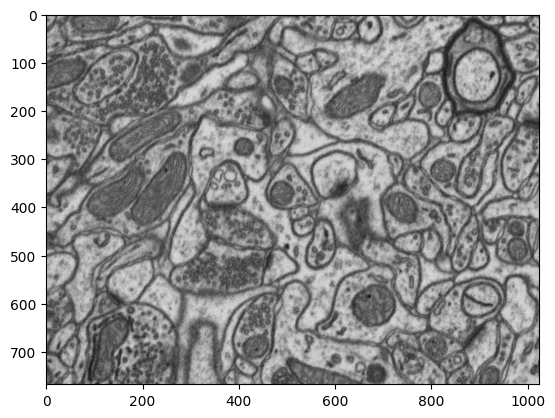

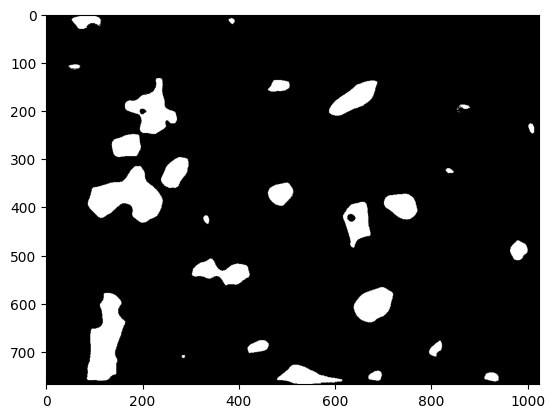

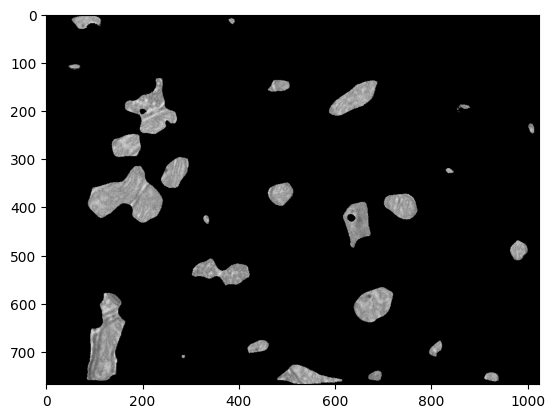

In [41]:
# Assuming predict_test is your model output and x_test is the normalized test image
thresholded_mask = (predict_test > 0.5).astype(np.uint8)

# Display original image
plt.imshow(x_test[1], cmap='gray')
plt.show()

# Display predicted mask
plt.imshow(thresholded_mask[1], cmap='gray')
plt.show()

# Overlay the mask on the image
overlay = np.where(thresholded_mask[1], x_test[1], 0)  # This will show the mask in place of the original image
plt.imshow(overlay, cmap='gray')
plt.show()

In [43]:
x_test =tiff.imread('/content/drive/MyDrive/intenship/testing.tif')
y_test = tiff.imread('/content/drive/MyDrive/intenship/testing_groundtruth.tif')

In [42]:
model.save('/content/drive/MyDrive/intenship/doubleu_model.h5')

In [44]:
def preprocss_data(df):
  df = df.astype('float32') / 255.0
  return df

In [45]:
y_test = preprocss_data(y_test)
x_test = preprocss_data(x_test)

InvalidArgumentError: ignored

In [48]:
predictions_thresholded = (predictions > 0.5).astype(np.uint8)


NameError: ignored